In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


unique oaid_hash: 6510316 



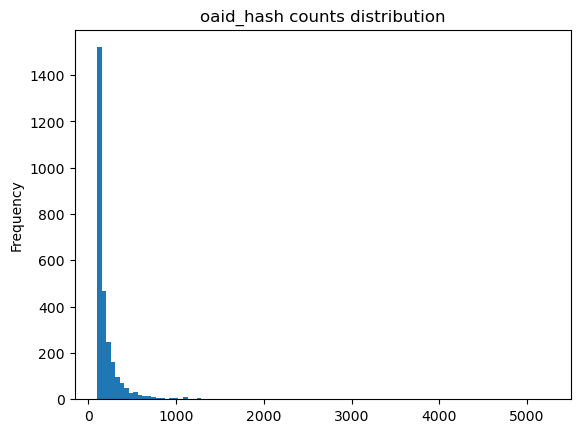

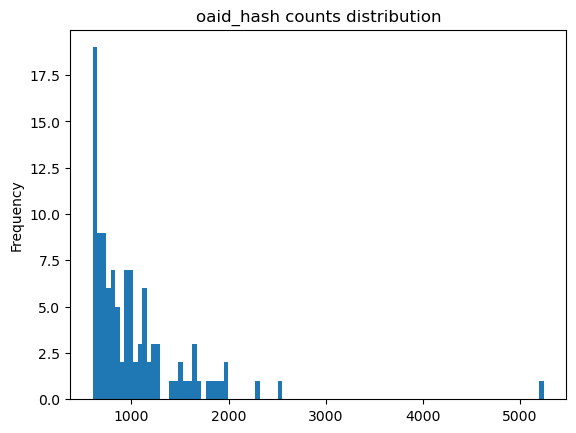

In [14]:
print(f'unique oaid_hash: {len(pd.unique(data["oaid_hash"]))} \n')

counts = pd.value_counts(data['oaid_hash'])
counts[counts > 100].plot.hist(bins=100, title='oaid_hash counts distribution')
plt.show()

counts = pd.value_counts(data['oaid_hash'])
counts[counts > 600].plot.hist(bins=100, title='oaid_hash counts distribution')
plt.show()

Давайте объединим в одну категорию все редкие хэши, оставим отдельно только те, которые встречаются хотя бы n раз. n подберем.

Upd: Как оказалось, и без этих наворотов модель хорошо обучается.

In [3]:
def feature_engineering(data_: pd.DataFrame):
    data = data_.copy()

    # drop features
    data = data.drop(["banner_id0", "banner_id1", "rate0", "rate1", "g0", "g1", "coeff_sum0", "coeff_sum1", "impressions"], axis=1)

    # oaid_hash
    #uniq, counts = np.unique(data['oaid_hash'], return_counts=True)
    #hash_to_count = {h : c for h, c in zip(uniq, counts)}
    #hash_to_indx = dict()
    #indx = 1
    #n = 1
    #for h in uniq:
    #    if hash_to_count[h] > n:
    #        hash_to_indx[h] = indx
    #        indx += 1
    #data['oaid_hash'] = [hash_to_indx[h] if hash_to_count[h] > n else 0 for h in data['oaid_hash'].values]

    # add log to campaign_clicks
    # data['campaign_clicks'] = np.log(data['campaign_clicks'] + 1e-5)

    data['date_time'] = pd.to_datetime(data['date_time'])

    # split hour feature to two categorical features
    #hours_counts_if_clicks = data[data['clicks'] == 1]['date_time'].dt.hour.value_counts(sort=False).sort_index()
    #hours_counts = data['date_time'].dt.hour.value_counts(sort=False).sort_index()
    #stat = [h_cnt_if_cl / h_cnt for h_cnt_if_cl, h_cnt in zip(hours_counts_if_clicks, hours_counts)]
    #median = np.median(stat)
    #data['hour'] = np.array([0 if stat[h] < median else 1 for h in data['date_time'].dt.hour])

    # add day_of_week feature
    #data['day_of_week'] = data['date_time'].dt.dayofweek

    # split train-test
    train = data[data['date_time'].dt.date < pd.to_datetime('2021-10-01')]
    test = data[data['date_time'].dt.date == pd.to_datetime('2021-10-02')]
    val = data[data['date_time'].dt.date == pd.to_datetime('2021-10-01')]

    features = ["os_id", "zone_id", "banner_id", "country_id", "oaid_hash"]

    X_train = train[features]
    X_test = test[features]
    X_val = val[features]

    y_train, y_test, y_val = train['clicks'], test['clicks'], val['clicks']

    return X_train, X_test, X_val, y_train, y_test, y_val

In [4]:
X_train, X_test, X_val, y_train, y_test, y_val = feature_engineering(data)

/home/ekaterina/.local/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [41]:
print('data sizes: ', X_train.shape, X_test.shape, X_val.shape)

data sizes:  (12049046, 5) (2128978, 5) (1643448, 5)


In [42]:
X_train.head()

,os_id,zone_id,banner_id,country_id,oaid_hash
0,0,0,0,0,5664530014561852622
1,0,1,1,1,5186611064559013950
2,0,2,2,0,2215519569292448030
3,1,3,3,1,6262169206735077204
4,1,4,4,0,4778985830203613115


Признаки: ['os_id', 'zone_id', 'banner_id', 'country_id', 'oaid_hash']

Изначально я хотела оставить campaign_clicks, data и изменить oaid_hash, но в итоге лучше всего показывает именно такой набор признаков.

Приведем данные к ffm формату. Для себя для справки (взято с https://github.com/ycjuan/libffm):

Data Format

The data format of LIBFFM is:

\<label\> \<field1\>:\<feature1\>:\<value1\> \<field2\>:\<feature2\>:\<value2\> ...
.
.
.

'field' and 'feature' should be non-negative integers. See an example ''bigdata.tr.txt.'

It is important to understand the difference between 'field' and 'feature'. For example, if we have a raw data like this:

Click  Advertiser  Publisher
=====  ==========  =========
    0        Nike        CNN
    1        ESPN        BBC

Here, we have

    * 2 fields: Advertiser and Publisher

    * 4 features: Advertiser-Nike, Advertiser-ESPN, Publisher-CNN, Publisher-BBC

Usually you will need to build two dictionares, one for field and one for features, like this:

    DictField[Advertiser] -> 0
    DictField[Publisher]  -> 1

    DictFeature[Advertiser-Nike] -> 0
    DictFeature[Publisher-CNN]   -> 1
    DictFeature[Advertiser-ESPN] -> 2
    DictFeature[Publisher-BBC]   -> 3

Then, you can generate FFM format data:

    0 0:0:1 1:1:1
    1 0:2:1 1:3:1

Note that because these features are categorical, the values here are all ones.

In [5]:
from tqdm import tqdm


class Transform:
    def __init__(self):
        self.field_index = None
        self.feature_index = None

    def transform_row(self, row):
        ffm = [str(int(np.array(row[row.index == 'clicks'])[0])),] # get 'clicks' value

        col_val = row[row.index != 'clicks'].to_dict().items()
        for col, val in col_val:
            if col == 'campaign_clicks':
                # for num features = ['campaign_clicks']
                ffm.append(f'{self.field_index[col]}:{self.feature_index[col]}:{val}')
            else:
                # for cat features
                name = f'{col}_{int(val)}'
                ffm.append(f'{self.field_index[col]}:{self.feature_index[name]}:1')
        return ' '.join(ffm)

    def transform_to_ffm_format(self, X, y, output):
        # data = pd.DataFrame.sparse.from_spmatrix(X)
        data = X.copy()
        data['clicks'] = np.array(y)

        self.feature_index = dict()
        last_idx = 0
        self.field_index = {col: i for i, col in enumerate(X)}

        for col in data.columns:
            vals = data[col].unique()
            for val in vals:
                if col in ['campaign_clicks']:
                    name = f'{col}_{val}'
                else:
                    name = f'{col}_{int(val)}'
                if name not in self.feature_index:
                    self.feature_index[name] = last_idx
                    last_idx += 1
            self.feature_index[col] = last_idx
            last_idx += 1

        #with open(output, "w") as file:
        #    with tqdm(total=data.shape[0]) as pb:
        #        for _, row in data.iterrows():
        #            print(self.transform_row(row))
        #            file.write(self.transform_row(row))
        #            pb.update(1)
        ffm_data = pd.Series({idx: self.transform_row(row) for idx, row in tqdm(data.iterrows(), total=data.shape[0])})
        ffm_data.to_csv(output, index=False)


In [43]:
t = Transform()
t.transform_to_ffm_format(X_train, y_train, 'train_4.txt')

100%|██████████| 12049046/12049046 [35:58<00:00, 5582.21it/s]


In [44]:
t = Transform()
t.transform_to_ffm_format(X_val, y_val, 'val_4.txt')
t.transform_to_ffm_format(X_test, y_test, 'test_4.txt')

100%|██████████| 2128978/2128978 [06:20<00:00, 5592.29it/s]


In [9]:
!pip install xlearn

In [5]:
import xlearn as xl
xl.hello()

In [6]:
import os
os.environ['USER'] = 'xlearn'

In [8]:
from sklearn.model_selection import ParameterGrid
import xlearn as xl
from sklearn.metrics import log_loss, roc_auc_score

params_grid = {
    'task': ['binary'],
    'lr': [0.1],
    'lambda':[0.0001, 0.001],
    'k': [2],
    'metric': ['auc'],
    'epoch': [30]
}

for params in ParameterGrid(params_grid):
    print(f'params: {params}\n')
    ffm_model = xl.create_ffm()
    ffm_model.setTrain("train_4.txt")
    ffm_model.setValidate("val_4.txt")
    ffm_model.setSigmoid()
    ffm_model.setQuiet()
    ffm_model.fit(params, "model.out")

    ffm_model.setTest("val_4.txt")
    ffm_model.predict("model.out", "output")
    y_pred = pd.read_csv('output', header=None)
    print(f'roc {round(roc_auc_score(y_val, y_pred), 3)}, loss {round(log_loss(y_val, y_pred), 3)}')

params: {'epoch': 30, 'k': 2, 'lambda': 0.0001, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Pro

In [7]:
from sklearn.model_selection import ParameterGrid
import xlearn as xl
from sklearn.metrics import log_loss, roc_auc_score

params_grid = {
    'task': ['binary'],
    'lr': [0.1],
    'lambda':[0.01],
    'k': [2, 4],
    'metric': ['auc'],
    'epoch': [30]
}

for params in ParameterGrid(params_grid):
    print(f'params: {params}\n')
    ffm_model = xl.create_ffm()
    ffm_model.setTrain("train_4.txt")
    ffm_model.setValidate("val_4.txt")
    ffm_model.setSigmoid()
    ffm_model.setQuiet()
    ffm_model.fit(params, "model.out")

    ffm_model.setTest("val_4.txt")
    ffm_model.predict("model.out", "output")
    y_pred = pd.read_csv('output', header=None)
    print(f'roc {round(roc_auc_score(y_val, y_pred), 3)}, loss {round(log_loss(y_val, y_pred), 3)}')

params: {'epoch': 30, 'k': 2, 'lambda': 0.01, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Probl

Мой ноутбук не выдерживает натиск модели, поэтому его хватает всего на два прогона, прежде чем все умрет с переполнением памяти. Поэтому кроссвалидации здесь нет, и я просто считаю скор на валидационном датасете один раз. По результатам экспериментов, я беру лучшие параметры.

In [9]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("train_4.txt")
params = {
    'task': 'binary',
    'lr': 0.1,
    'lambda':0.01,
    'k':2,
    'metric':'auc',
    'epoch':20
}
ffm_model.setTest("test_4.txt")
ffm_model.setSigmoid()
ffm_model.fit(params, "model.out")

ffm_model.predict("model.out", "output")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x auc) option.
[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train_4.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 5010227
[------------] Number of Field: 5
[------------] Time cost for reading problem: 11.22 (sec)
[ ACTION     ] Initia

In [10]:
from sklearn.metrics import log_loss, roc_auc_score


y_pred = pd.read_csv('output', header=None)
print(f'roc {round(roc_auc_score(y_test, y_pred), 3)}, loss {round(log_loss(y_test, y_pred), 3)}')

roc 0.729, loss 0.148


Линейная модель:
roc 0.78, loss 0.134

Ffm:
roc 0.73, loss 0.148

ffm не победила линейную модель. Но я думаю, что нужно было просто еще попытаться подобрать параметры или изменить набор признаков. Но у меня уже не хватает времени и мощностей.